# Data preprocessing

CML and ref wet/dry data loading, inspecting, preprocessing and building dataset.  

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: Inspired by__  
Pytorch CML w/d - github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
Pycomlink - github: https://github.com/pycomlink/pycomlink/tree/master  
thesis: https://doi.org/10.5194/amt-13-3835-2020 [2]  

In [1]:
import xarray as xr               # work with arrays, also possible with pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Load data
Import data of 500 CML links from pycomlink with 1min timestep.  
Reference path averaged RADOLAN rain rate data aligned with all 500 CML IDs with 5 min time step.

In [16]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
# reference RADOLAN 5 min time step
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')
ref_set = ref_set.rename_vars({'rainfall_amount':'rain'})

In [17]:
cml_list = [cml_set.isel(cml_id=i) for i in range(len(cml_set.cml_id))]

In [18]:
for cml in cml_list:
    # Check for fault data in TSL, RSL and replace it with NaN https://github.com/jpolz/cml_wd_pytorch/tree/main
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    # Calculate TRSL
    cml['trsl'] = cml.tsl - cml.rsl
    # Iterpolate missing values: From pycomlink
    cml['trsl'] = cml.trsl.interpolate_na(dim='time', method='linear', max_gap='5min')
    
    cml['trsl_gap'] = (('time'), np.logical_or(np.isnan(cml.trsl.values[0]), np.isnan(cml.trsl.values[1])))

In [19]:
ref_list = [ref_set.isel(cml_id=i) for i in range(len(ref_set.cml_id))]  

In [20]:
for ref in ref_list:
    ref['rain'] = ref.rain.interpolate_na(dim='time', method='linear', max_gap='20min')
    # From reference rain rate derivate boolean reference Wet/Dry signal
    ref['ref_wd'] = ref.rain.where(ref.rain == 0, True).astype(bool) # ChatGPT


#### Dataset statistics

In [7]:
'''
print('maximal length: ', max(cml_set.length.values),
      '\nminimal length: ', min(cml_set.length.values),
      '\naverage length: ', cml_set.length.values.mean())

print('maximal frequency: ', max(cml_set.frequency.values.reshape(-1)/1e9),
      '\nminimal frequency: ', min(cml_set.frequency.values.reshape(-1)/1e9),
      '\naverage frequency: ', cml_set.frequency.values.reshape(-1).mean()/1e9)
'''

maximal length:  28.618299048648108 
minimal length:  0.5151045976790105 
average length:  7.239217429848066
maximal frequency:  38.85 
minimal frequency:  6.46 
average frequency:  26.189208


In [8]:
#print('Rate of Vertical pol.: ',cml_set.polarization.values.reshape(-1).tolist().count('V')/len(cml_set.polarization.values.reshape(-1)))

Rate of Vertical pol.:  0.9


In [9]:
# get boolean flag for trsl missing values
'''
cml_set['tsl_gap'] = (
        ('cml_id', 'time'), 
        np.logical_or(np.isnan(cml_set.tsl.isel(channel_id=0).values), np.isnan(cml_set.tsl.isel(channel_id=1).values))
)

cml_set['rsl_gap'] = (
        ('cml_id', 'time'), 
        np.logical_or(np.isnan(cml_set.rsl.isel(channel_id=0).values), np.isnan(cml_set.rsl.isel(channel_id=1).values))
)
cml_set['gap'] = cml_set.rsl_gap | cml_set.tsl_gap
'''

In [10]:
#print('data is available in: ',sum(~cml_set.gap.values.reshape(-1))/len(cml_set.tsl_gap.values.reshape(-1)))

data is available in:  0.9911501262626262


#### Plot and inspect the data

In [21]:
# select one cml:
k = 16
my_cml = cml_list[k]
my_ref = ref_list[k]

# shaded refernece wet periods from Pycomlink
# set first and last value with zero for correct plotting
my_ref['ref_wd'][0] = False
my_ref['ref_wd'][-1] = False
my_cml['trsl_gap'][:,0] = False
my_cml['trsl_gap'][:,-1] = False

# setup figure
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,4))
#ax1 = axs[0].twiny()
#fig.tight_layout()

# plot TRSL
my_cml.tsl.plot.line(x='time', ax=axs[0], label = 'TL');
# plot Rain rate 
my_ref.rain.plot.line(x='time', ax=axs[1], label = 'TL');

# plot real bool wet/dry with 5min precission
wet_start = np.roll(my_ref.ref_wd, -1) & ~my_ref.ref_wd
wet_end = np.roll(my_ref.ref_wd, 1) & ~my_ref.ref_wd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[1].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
    axs[0].axvspan(my_ref.time.values[wet_start_i], my_ref.ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
   

# plot trsl gaps
gap_start = np.roll(my_cml.trsl_gap[0], -1) & ~my_cml.trsl_gap[0]
gap_end = np.roll(my_cml.trsl_gap[0], 1) & ~my_cml.trsl_gap[0]
for gap_start_i, gap_end_i in zip(
    gap_start.values.nonzero()[0],
    gap_end.values.nonzero()[0],
):
    axs[0].axvspan(my_cml.time.values[gap_start_i], my_cml.time.values[gap_end_i], color='r', alpha=0.7, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
   


# axes limits source: https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_xlim.html
axs[1].set_xlim(my_cml.time.values[0], my_cml.time.values[-1])
axs[0].set_xlabel('')
axs[1].set_title("")

IndexError: too many indices

#### Plot all cmls with rain periods for data inspection


KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x000002A3B9E13F60> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



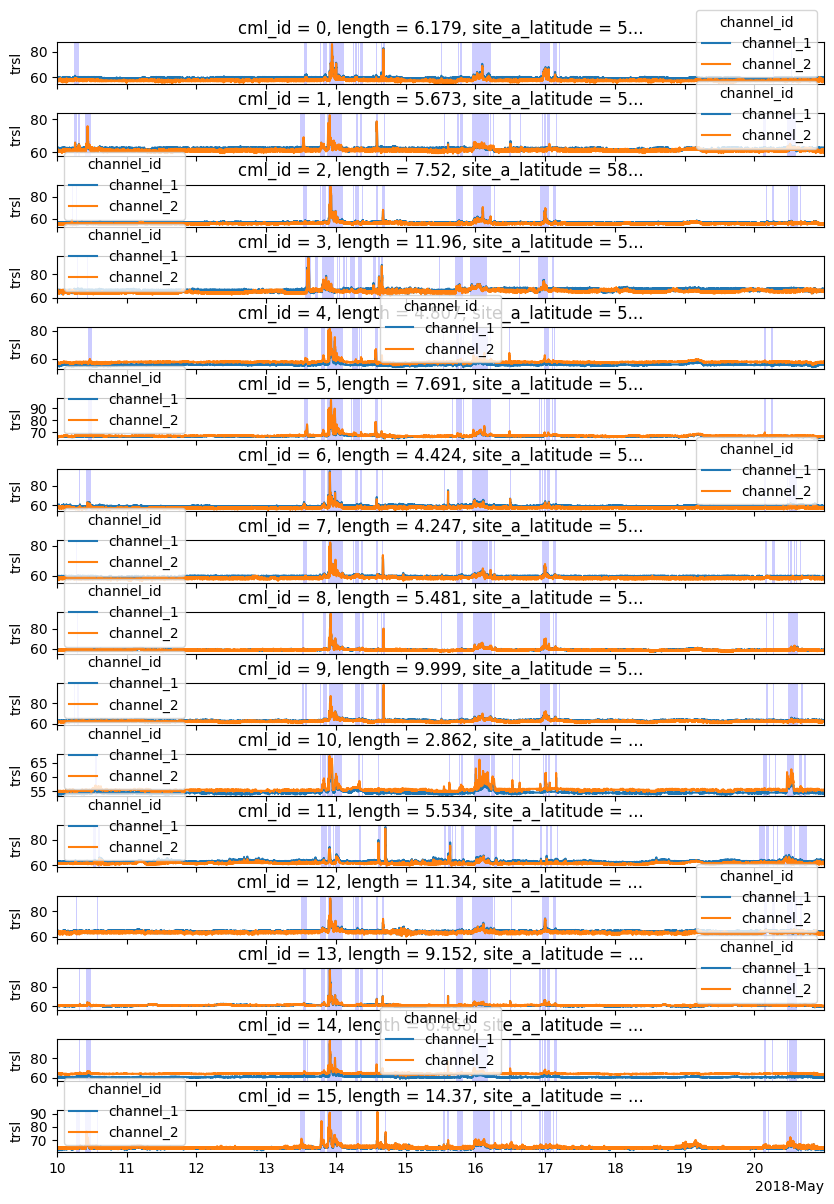

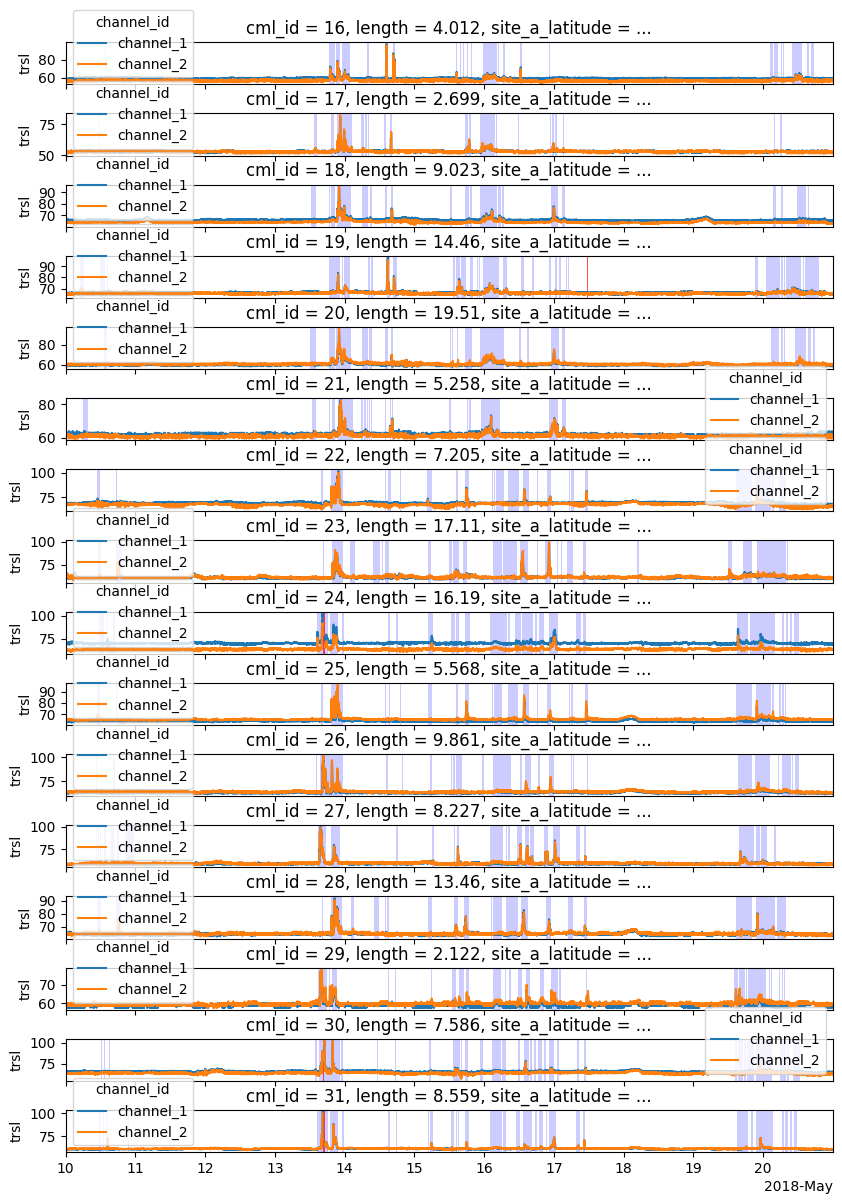

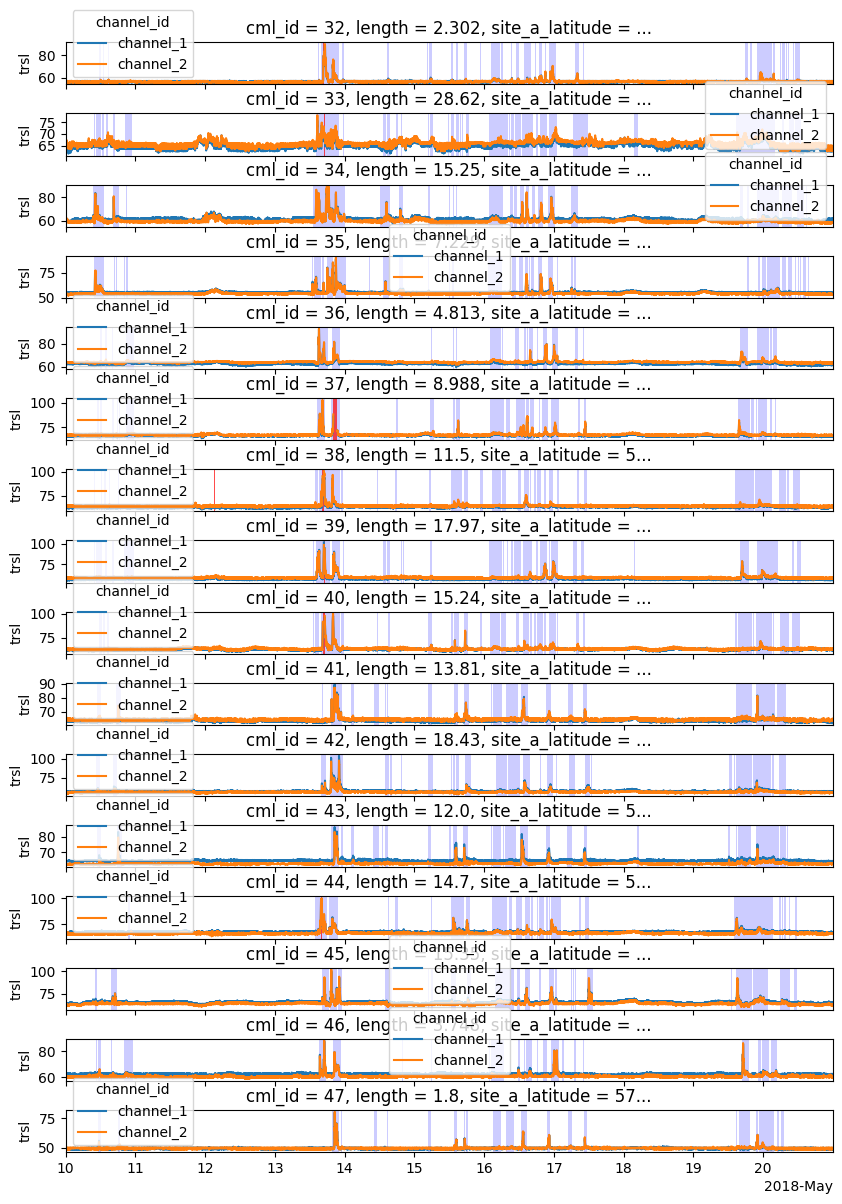

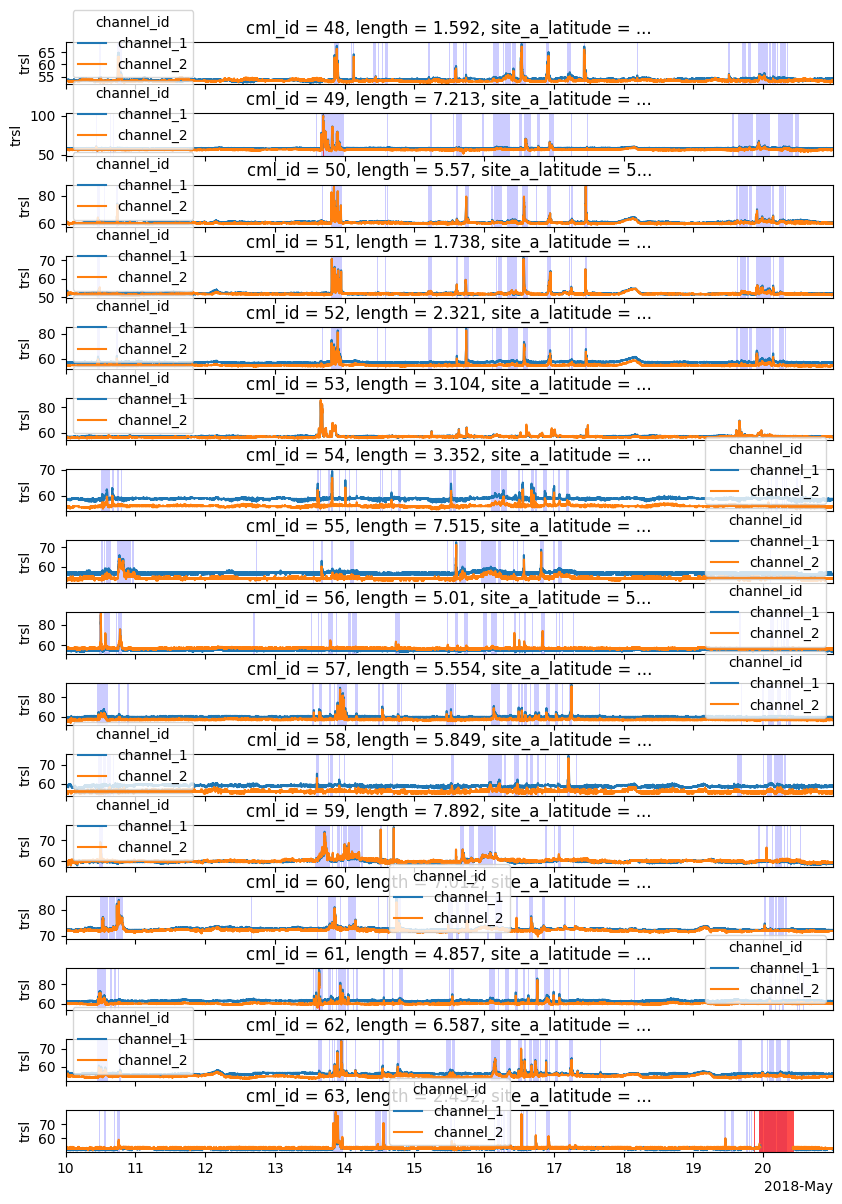

Error in callback <function flush_figures at 0x000002A3CE373880> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [12]:
N = 31

for n in range(N):
    K = 16
    # setup figure
    fig, axs = plt.subplots(K, 1, sharex=True, figsize=(8.267,11.692))
    fig.tight_layout()
    
    for k in range(K):    
        # shaded refernece wet periods from Pycomlink
        # set first and last value with zero for correct plotting
        ref_list[n*K+k]['ref_wd'][0] = False
        ref_list[n*K+k]['ref_wd'][-1] = False
       
        # plot TRSL
        cml_list[n*K+k].trsl.plot.line(x='time', ax=axs[k], label = 'TL');
        # plot Rain rate 
        #my_ref.rain.plot.line(x='time', ax=axs[1], label = 'TL');
        
        # plot real bool wet/dry with 5min precission
        wet_start = np.roll(ref_list[n*K+k].ref_wd, -1) & ~ref_list[n*K+k].ref_wd
        wet_end = np.roll(ref_list[n*K+k].ref_wd, 1) & ~ref_list[n*K+k].ref_wd
        for wet_start_i, wet_end_i in zip(
            wet_start.values.nonzero()[0],
            wet_end.values.nonzero()[0],
        ):
            axs[k].axvspan(ref_list[n*K+k].time.values[wet_start_i], ref_list[n*K+k].ref_wd.time.values[wet_end_i], color='b', alpha=0.2, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html

        cml_list[n*K+k]['trsl_gap'][0] = False
        cml_list[n*K+k]['trsl_gap'][-1] = False
        # plot trsl gaps
        gap_start = np.roll(cml_list[n*K+k].trsl_gap, -1) & ~cml_list[n*K+k].trsl_gap
        gap_end = np.roll(cml_list[n*K+k].trsl_gap, 1) & ~cml_list[n*K+k].trsl_gap
        for gap_start_i, gap_end_i in zip(
            gap_start.values.nonzero()[0],
            gap_end.values.nonzero()[0],
        ):
            axs[k].axvspan(cml_list[n*K+k].time.values[gap_start_i], cml_list[n*K+k].time.values[gap_end_i], color='r', alpha=0.7, linewidth=0); # https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.axvspan.html
   


        
        axs[k].set_xlim(cml_list[n*K+k].time.values[0], cml_list[n+k].time.values[-1])
        axs[k].set_xlabel('')
    #fig.show()
    fig.savefig('cml' + str(n) + '.pdf') 

#### <span style="color:red">TODO: </span>Detect higher fault periods

#### <span style="color:red">TODO: </span>Export dataset